In [133]:
import torch
import pandas as pd
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
#from torchsample.callbacks import EarlyStopping

In [2]:
from models import SqueezeNet
from models import CNN_model
from data_preparation import load_dataset, augmentation, convert
from trainer import Trainer

In [140]:
#images, matched with labels
data = pd.read_csv('C:/Users/BOZ/Zoetis_BCS/CNN_dataset/training_labels2.csv',index_col=False)
data_path = 'C:/Users/BOZ/Zoetis_BCS/CNN_dataset/whole/'

In [141]:
#load data/labels from image folder and excel form, as training data/labels
train_x, val_x, train_y, val_y = load_dataset(img_names=data['image_names'], data_path=data_path, labels = data['new_label'].values)

100%|████████████████████████████████████████████████████████████████████████████████| 604/604 [00:08<00:00, 71.20it/s]


training set:  (604, 224, 224, 3) 	 trainng label:  (604,)
training set:  ((483, 224, 224, 3), (483,)) 	 testing set:  ((121, 224, 224, 3), (121,))


In [142]:
#expand the dataset by augmentation
train_x,train_y = augmentation(train_x,train_y)
#convert the data to torch tensors for training
train_x,train_y,val_x,val_y = convert(train_x,train_y,val_x,val_y)

100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [00:11<00:00, 41.40it/s]


In [57]:
#training process
def train_evaluate(params,model):
    optimizer = Adam(model.parameters(), lr=params['lr'])
    criterion = CrossEntropyLoss()
    trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_x=train_x, train_y=train_y,val_x=val_x,val_y=val_y) 
    train_losses, train_accs, validation_losses, validation_accs, predictions_test = trainer.train_val(n_epochs=params['n_epochs'],batch_size=params['batch_size'])
    return (train_losses, train_accs), (validation_losses, validation_accs), predictions_test

In [131]:
# training params
params = {
          "lr": 0.000075, 
          "batch_size": 24,
          "n_epochs": 50,
          "patience": 5 
         }
# traing and evaluating  process
model1 = CNN_model(num_classes=6)
model2 = SqueezeNet(version=1.0,num_classes=6)
(train_losses, train_accs), (validation_losses, validation_accs), predictions = train_evaluate(params,model1) 

SyntaxError: invalid syntax (<ipython-input-131-9b8febb5a630>, line 7)

In [83]:
'''
PATH = 'C:/Users/BOZ/Zoetis_BCS/CNN_dataset/CNN.h5'
torch.save(model1.state_dict(), PATH)

'''

'''
load model

model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

'''

'\nload model\n\nmodel = Net()\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n\n'

In [60]:
Results = pd.DataFrame({'train_loss':train_losses, 'train_acc': train_accs, 'val_loss:': validation_losses, 'val_acc': validation_accs})
P_L = pd.DataFrame({'label': val_y, 'prediction': predictions})
Final_results = pd.concat([Results,P_L],axis=1)
Final_results.to_excel('CNN_Results.xlsx')
Final_results

,train_loss,train_acc,val_loss:,val_acc,label,prediction
0,1.644192,0.342,1.472205,0.421,3.0,3
1,1.397949,0.424,1.298821,0.471,2.0,2
2,1.252814,0.463,1.224078,0.479,2.0,2
3,1.110061,0.526,1.019859,0.587,3.0,4
4,1.012858,0.582,0.910169,0.645,1.0,1
...,...,...,...,...,...,...
116,NaN,NaN,NaN,NaN,4.0,4
117,NaN,NaN,NaN,NaN,0.0,0
118,NaN,NaN,NaN,NaN,4.0,4
119,NaN,NaN,NaN,NaN,2.0,2


In [86]:
#train_accs = [float(x) for x in train_accs]
#validation_accs = [float(x) for x in validation_accs]

Text(0.5, 0, 'epoch')

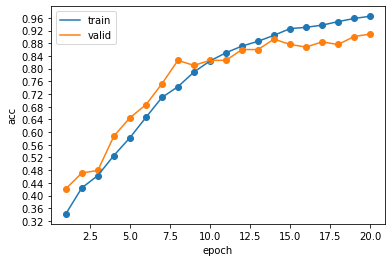

In [91]:
fig, ax = plt.subplots(1, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.04))
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, validation_accs, label="valid");
plt.scatter(epochs, train_accs)
plt.scatter(epochs, validation_accs);
plt.legend()
plt.ylabel("acc")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

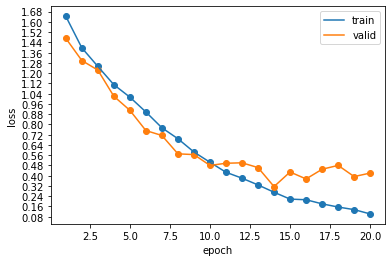

In [65]:
fig, ax = plt.subplots(1, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.08))
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, validation_losses, label="valid");
plt.scatter(epochs, train_losses)
plt.scatter(epochs, validation_losses);
plt.legend()
plt.ylabel("loss")
plt.xlabel("epoch")

<ipython-input-145-85cd2b0361ab>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-145-85cd2b0361ab>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


Text(0, 0.5, 'Predicted BCS')

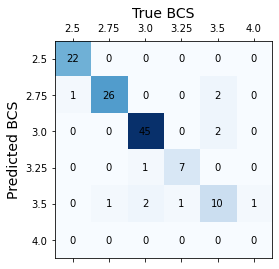

In [145]:
alpha = ['2.5','2.75','3.0','3.25','3.5','4.0']
conf_matrix = confusion_matrix(val_y, predictions)
data_conf = conf_matrix.transpose()  
_, ax = plt.subplots()
ax.matshow(data_conf, cmap="Blues")
# printing exact numbers
for (i, j), z in np.ndenumerate(data_conf):
    ax.text(j, i, '{}'.format(z), ha='center', va='center')
# axis formatting 
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("True BCS".format(" "*18), fontsize=14)
plt.ylabel("Predicted BCS".format(" "*18), fontsize=14)

In [139]:
#test on the whole dataset
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

100%|████████████████████████████████████████████████████████████████████████████████| 604/604 [00:08<00:00, 70.71it/s]


In [155]:
def confusion_matrix_display(labels, predictions): 
    test_acc = accuracy_score(labels,predictions)
    alpha = ['2.5','2.75','3.0','3.25','3.5','4.0']
    conf_matrix = confusion_matrix(labels, predictions)
    data_conf = conf_matrix.transpose()  
    _, ax = plt.subplots()
    ax.matshow(data_conf, cmap="Blues")
    # printing exact numbers
    for (i, j), z in np.ndenumerate(data_conf):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    # axis formatting 
    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)
    plt.title("True BCS".format(" "*18), fontsize=14)
    plt.ylabel("Predicted BCS".format(" "*18), fontsize=14)

    return test_acc

In [170]:
def tester(test_img_path, data, model):
    imgs = data['image_names']
    cropped_imgs = []
    for img_name in tqdm(imgs):
        img_path =  test_img_path + img_name
        img = imread(img_path)
        img_resized = resize(img,(224,224),anti_aliasing=True)
        cropped_imgs.append(img_resized)

    whole_x = np.array(cropped_imgs)
    whole_y = data['new_label'].values
    
    whole_x = whole_x.reshape(len(whole_y), 3, 224, 224)
    
    #transform the array data to tensors
    whole_x  = torch.from_numpy(whole_x)
    whole_x = whole_x.float()
    #use models to make predictions
    predicted = model(whole_x)
    
    softmax_test = torch.exp(predicted)
    prob_test = list(softmax_test.detach().numpy())
    predictions_test = np.argmax(prob_test, axis=1)
    
    return whole_y, predictions_test

In [171]:
labels, predictions_test = tester(data_path,data,model1)

100%|████████████████████████████████████████████████████████████████████████████████| 604/604 [00:09<00:00, 64.55it/s]


<ipython-input-155-444b6e913ba4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-155-444b6e913ba4>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


0.9768211920529801


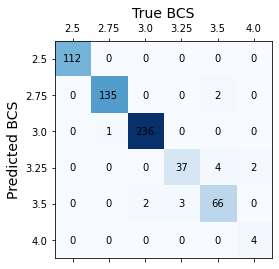

In [173]:
test_acc = confusion_matrix_display(labels, predictions_test)
print(test_acc)